In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_datareader import data as wb

In [2]:
data=pd.DataFrame()
stocks = ['RELIANCE.NS', 'AMZN', 'AAPL', 'INFY.NS', 'TSLA']
for stock in stocks:
    data[stock] = wb.DataReader(stock, data_source = 'yahoo', start = '2015-1-1')['Adj Close']

In [3]:
data.dropna(inplace=True)
data

,RELIANCE.NS,AMZN,AAPL,INFY.NS,TSLA
Date,,,,,
2015-01-02,418.137756,308.519989,24.745996,420.187622,43.862000
2015-01-05,413.557587,302.190002,24.048862,416.576813,42.018002
2015-01-06,394.788452,295.290009,24.051126,407.873322,42.256001
2015-01-07,403.382172,298.420013,24.388371,409.824860,42.189999
2015-01-08,397.597961,300.459991,25.325432,411.891083,42.124001
...,...,...,...,...,...
2021-11-22,2363.750000,3572.570068,161.020004,1759.400024,1156.869995
2021-11-23,2385.850098,3580.040039,161.410004,1736.900024,1109.030029
2021-11-24,2351.399902,3580.409912,161.940002,1696.000000,1116.000000


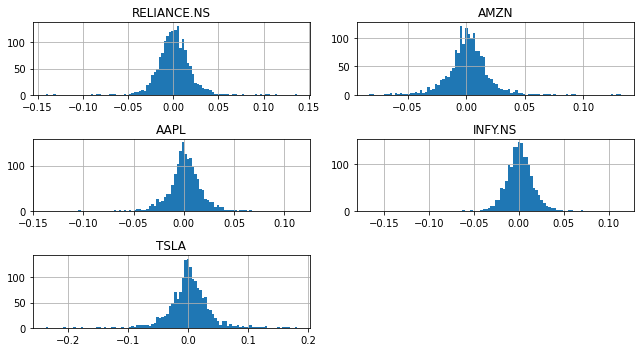

In [4]:
log_ret = np.log(data/data.shift(1))
log_ret.hist(bins=100,figsize=(9,5))
plt.tight_layout()

In [5]:
log_ret.mean()*252

RELIANCE.NS    0.269170
AMZN           0.373145
AAPL           0.284951
INFY.NS        0.212878
TSLA           0.496539
dtype: float64

In [6]:
log_ret.cov()*252

,RELIANCE.NS,AMZN,AAPL,INFY.NS,TSLA
RELIANCE.NS,0.089907,0.008156,0.011595,0.020434,0.018365
AMZN,0.008156,0.093933,0.049550,0.009180,0.059398
AAPL,0.011595,0.049550,0.087780,0.010987,0.064571
INFY.NS,0.020434,0.009180,0.010987,0.077058,0.018579
TSLA,0.018365,0.059398,0.064571,0.018579,0.313848


In [7]:
log_ret.corr()

,RELIANCE.NS,AMZN,AAPL,INFY.NS,TSLA
RELIANCE.NS,1.000000,0.088756,0.130524,0.245502,0.109330
AMZN,0.088756,1.000000,0.545679,0.107902,0.345941
AAPL,0.130524,0.545679,1.000000,0.133585,0.389029
INFY.NS,0.245502,0.107902,0.133585,1.000000,0.119468
TSLA,0.109330,0.345941,0.389029,0.119468,1.000000


** FIND EFFICIENT FRONTIER AND OPTIMAL WEIGHTS**

In [8]:
from scipy.optimize import minimize

In [9]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    rf=0.05
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = (ret-rf)/vol
    return np.array([ret,vol,sr])

In [10]:
#Here Optimization works as a minimization function, since we actually want to maximize the Sharpe Ratio, 
#we will need to turn it negative so we can minimize the negative sharpe 
#(same as maximizing the postive sharpe)
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1


#constraint 
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})


# 0 to 1 bounds for each weight if long only portfolio; -1 to 1 bounds if long+short portfolio
bounds = ((-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1))


# Initial Guess (equal distribution)
init_guess = [0.2]*5

In [11]:
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [12]:
opt_results

     fun: -1.3371090105850199
     jac: array([-0.24268965, -0.241945  , -0.24270838, -0.24254216, -0.24441692])
 message: 'Optimization terminated successfully'
    nfev: 44
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.27178254, 0.39377644, 0.05368836, 0.17333031, 0.10742236])

**Optimal Allocation for our Portfolio

In [13]:
opt_results.x

array([0.27178254, 0.39377644, 0.05368836, 0.17333031, 0.10742236])

** Annualized return, Volatility and Sharpe Ratio of our Portfolio

In [14]:
get_ret_vol_sr(opt_results.x)

array([0.32562732, 0.20613676, 1.33710901])

In [15]:
get_ret_vol_sr(opt_results.x)
return_ = get_ret_vol_sr(opt_results.x)[0]
volatility_ = get_ret_vol_sr(opt_results.x)[1]
sharperatio_ = get_ret_vol_sr(opt_results.x)[2]
print('return =', round(return_ * 100, 2), '%')
print('volatility =', round(volatility_ * 100, 2), '%')
print('sharpe ratio =', round(sharperatio_, 4))

return = 32.56 %
volatility = 20.61 %
sharpe ratio = 1.3371


**Plotting Efficient frontier line**
[Previously we minimized negetive sharpe ratio(so as to maximize sharpe ratio)
Now, we will minimize Volatility]

In [16]:
#To minimize volatility-
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1]

In [17]:
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on since our efficient frontier is a line so 
# we need many points to plot the line and also we would need a for loop for calc each point
frontier_y = np.linspace(return_-0.1 , return_+0.1 , 100)

In [18]:
frontier_volatility = [] #to store the frontier line 

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

In [19]:
np.random.seed(101)

num_ports = 2000
all_weights = np.zeros((num_ports,len(data.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)
rf = 0.05

for ind in range(num_ports):
    weights = np.array(np.random.random(len(data.columns)))
    weights /=np.sum(weights)
    all_weights[ind,:] = weights
    
    ret_arr[ind] = np.sum((log_ret.mean() * weights) * 252)
    
    vol_arr[ind] = np.sqrt(np.dot(weights.T , np.dot(log_ret.cov()*252 , weights)))
    
    sharpe_arr[ind] = (ret_arr[ind] - rf)/vol_arr[ind]


Text(0.5, 1.0, 'Efficient Frontier line for our portfolio')

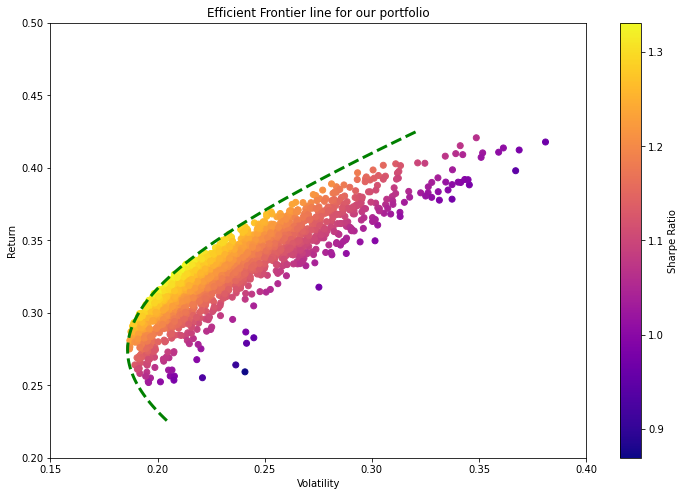

In [20]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.xlim([0.15,0.4])
plt.ylim([0.2,0.5])


# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)
plt.title('Efficient Frontier line for our portfolio')